In [19]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import requests
import pandas as pd
import os
from io import StringIO
import shutil

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

sns.set(style='white', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
from math import  exp

import seaborn as sns; sns.set(); sns.set_palette('bright')

In [20]:
def GetTargetModel(mu):
  models = [0.21, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
  dists = list(map(lambda x: np.round(np.abs(mu - x), 3), models))
  return np.argmin(dists)

#test of function
GetTargetModel(0.875)

6

In [28]:
sub_paths = ["../test_results/AllTestsTcsOn", "../test_results/AllTestsTcsOff"]

# Read in the CSV files locally using pandas
dfs = []
dfs_off = []
for sub_path in sub_paths:
  print(sub_path)
  for file in os.listdir(sub_path):
      print(str(file))
      if file.endswith('.csv'):
          file_path = os.path.join(sub_path, file)
          with open(file_path) as f:
              data = f.read()
          df = pd.read_csv(StringIO(data))
          #print(file_path)

          #calc acc and all othe rfields here
          df['acc'] = (df.speed.diff() / df.time.diff()).rolling(window=11).mean()
          df['jerk'] = (df.acc.diff() / df.time.diff()).rolling(window=15).mean()
          #df['predicted_acc'] = (df.desired_velocity - df.speed) * (2.0 * 7.51 / 7.0)
          #df['predicted_vel'] = (df.predicted_acc.shift(-1, axis=0,fill_value=0.0) * df.time.diff().shift(-1, axis=0,fill_value=0.0)) + df.speed # Måske forkert
          #df['slip_ratio'] = np.where(df.speed > df.predicted_vel, (df.speed - df.predicted_vel) / df.speed, (df.predicted_vel - df.speed) / df.speed)  # Måske forkert
  
          start_acc = 0.0
          start_vel = 0.0
          df['optimal_acc'] = 0.0
          df['optimal_vel'] = 0.0
          df['slip_ratio'] = 0.0
          
          df.time -= df.time.iloc[0]
          df['testDiff'] = df.time.diff()
          df.testDiff.iloc[0] = 0.0
          optimal_a_max = 7.51
          for n, time in enumerate(df.time):
            #print(df.testDiff.iloc[n-1],df.optimal_vel.iloc[n-1], df.speed.iloc[n-1],df.time.diff().iloc[n-1] ,n)
            df['optimal_acc'].iloc[n] = (df.desired_velocity.iloc[n] - start_vel) * (2.0 * optimal_a_max / 7.0) #2.0
            if df['optimal_acc'].iloc[n] > optimal_a_max:
              df['optimal_acc'].iloc[n] = optimal_a_max
            df['optimal_vel'].iloc[n] = (df['optimal_acc'].iloc[n] * df.testDiff.iloc[n]) + start_vel

            # New prev.
            start_vel = df['optimal_vel'].iloc[n]#*(df.desired_velocity.iloc[n] - start_vel)
          
          df['slip_ratio'] = np.where(df.speed == 0.0, 0.0, (df.expected_velocity-df.speed) / df.speed)

          #df['error_diff'] = df.expected_velocity-df.speed

          df['target_model'] = GetTargetModel(df.mu.iloc[0])

          df['target_vel'] = df.desired_velocity.iloc[-1]

          #append data
          if df.tcs_active.sum() > 1:
            #print(str(df.tcs_active.sum()))
            dfs.append(df)
          else:
            dfs_off.append(df)
      
    

# Concatenate all dataframes into a single dataframe
result = pd.concat(dfs)


print(result.head())


print(len(dfs))
print(len(dfs_off))

../test_results/AllTestsTcsOn
7_0.900_6.csv
6_0.800_5.csv
2_0.400_3.csv
6_0.200_5.csv
4_0.275_1.csv
5_0.425_2.csv
7_0.300_7.csv
7_0.700_3.csv
1_0.925_5.csv
1_0.200_4.csv
2_0.775_5.csv
3_0.350_5.csv
3_0.950_5.csv
5_0.375_3.csv
6_0.375_3.csv
5_0.875_6.csv
5_0.750_5.csv
7_0.200_6.csv
7_0.700_5.csv
1_0.200_7.csv
3_0.950_6.csv
6_0.250_3.csv
2_0.650_4.csv
5_0.300_7.csv
4_0.750_2.csv
6_0.450_7.csv
7_1.000_6.csv
4_0.100_6.csv
6_0.225_2.csv
1_0.150_1.csv
7_0.450_2.csv
5_0.775_4.csv
2_0.250_1.csv
2_0.200_5.csv
6_0.500_7.csv
7_0.725_6.csv
7_0.750_6.csv
1_0.475_7.csv
4_0.375_7.csv
6_0.100_2.csv
7_0.225_4.csv
6_0.100_5.csv
6_0.975_7.csv
6_0.375_4.csv
3_0.225_4.csv
2_0.175_4.csv
4_0.525_1.csv
6_0.500_2.csv
7_0.350_2.csv
3_0.800_1.csv
3_0.400_7.csv
7_0.200_7.csv
6_0.550_4.csv
5_0.800_4.csv
2_0.700_3.csv
4_0.350_4.csv
3_0.250_2.csv
4_0.925_6.csv
7_0.425_1.csv
3_0.850_2.csv
4_0.650_3.csv
4_0.600_5.csv
3_0.650_4.csv
5_0.250_4.csv
5_0.575_3.csv
1_0.250_7.csv
1_0.150_7.csv
4_0.975_5.csv
3_0.800_5.csv
1_0.

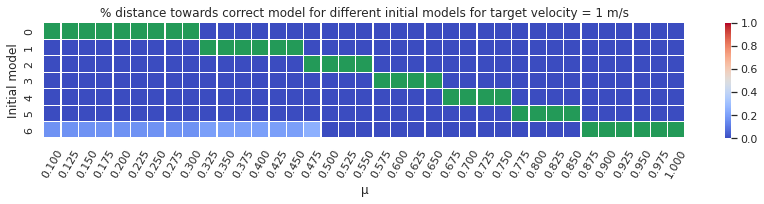

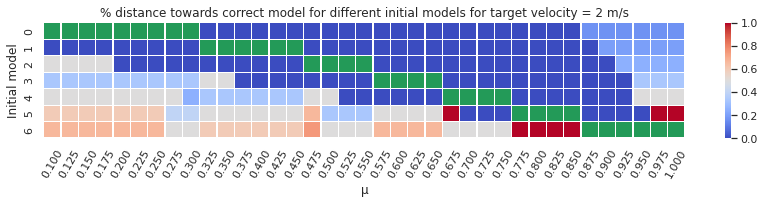

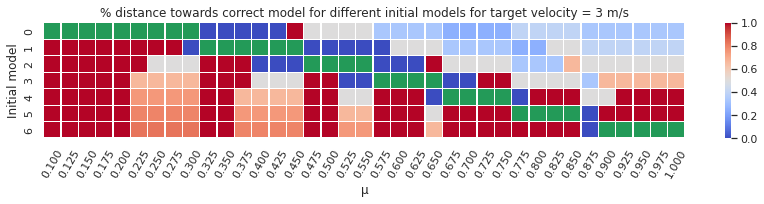

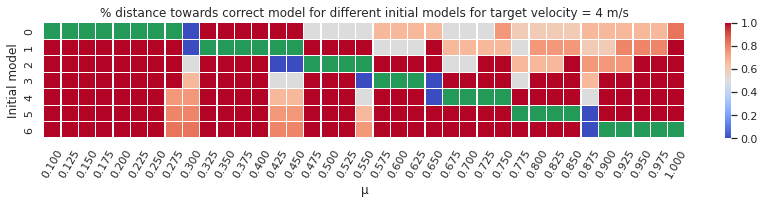

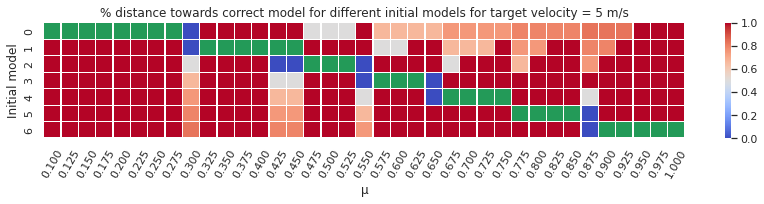

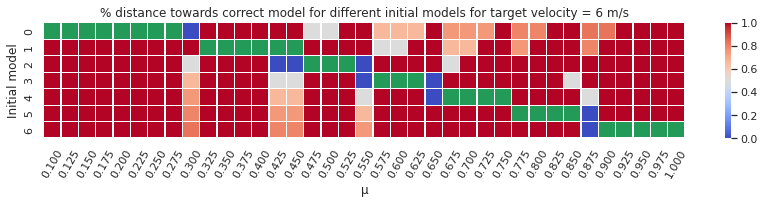

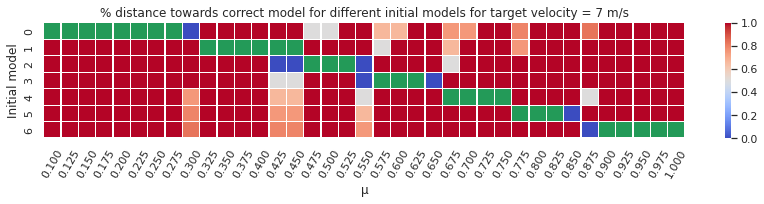

In [29]:
heatMap = np.zeros((7, 7, 37))
#print(heatMap.shape)
for i in range(len(dfs)):
  distance_to_correct_model_end = np.abs(dfs[i].target_model.iloc[0] - dfs[i].current_model.iloc[-1])
  distance_to_correct_model_start = np.abs(dfs[i].target_model.iloc[0] - dfs[i].current_model.iloc[0])
  #if int(dfs[i].current_model.iloc[0]) == 2 and dfs[i].mu.iloc[0] == 0.425:
  #  None
  if distance_to_correct_model_start != 0:
    heatMap[int(dfs[i].target_vel.iloc[0]) - 1, int(dfs[i].current_model.iloc[0]), int(np.round((dfs[i].mu.iloc[0] - 0.1) / 0.025))] += (np.abs(distance_to_correct_model_end-distance_to_correct_model_start) / distance_to_correct_model_start)
  elif distance_to_correct_model_end != 0:
    heatMap[int(dfs[i].target_vel.iloc[0]) - 1, int(dfs[i].current_model.iloc[0]), int(np.round((dfs[i].mu.iloc[0] - 0.1) / 0.025))] = 0
  else:
    heatMap[int(dfs[i].target_vel.iloc[0]) - 1, int(dfs[i].current_model.iloc[0]), int(np.round((dfs[i].mu.iloc[0] - 0.1) / 0.025))] = 1.00001

masked_data = np.ma.masked_where(heatMap == 1.00001, heatMap)
labelsx = np.round(np.linspace(0.1, 1.0, 37), 3)
labelsx = list(map(lambda x: "{:.3f}".format(x), labelsx))
labelsy = [0, 1, 2, 3, 4, 5, 6]

for i in range(7):
  df_cm = pd.DataFrame(heatMap[i], index = labelsy,
                    columns = labelsx)
  df_cmHe = pd.DataFrame(masked_data[i], index = labelsy,
                    columns = labelsx)

  #print(labelsx)
  plt.figure(figsize = (12,3))
  plt.title('% distance towards correct model for different initial models for target velocity = ' + str(i + 1) + ' m/s')
  plt.gca().set_facecolor('#239a58')
  # Get the QuadMesh object
  #plt.gca().get_children()[0].set_edgecolor('black')
  sns.heatmap(df_cmHe, annot=False, linewidths=0.3, linecolor='white', cmap='coolwarm',vmin=0.0, vmax=1.0)

  plt.xticks(rotation=60)
  plt.xlabel('\u03BC')
  plt.ylabel('Initial model')
  plt.tight_layout()
  plt.savefig('distanceCorrectInitialModelsTargvel' + str(i + 1) + '.pdf')
  plt.show()



(8, 37)
[0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3   0.325 0.35  0.375
 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675
 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975
 1.   ]


Text(66.5, 0.5, 'target vel')

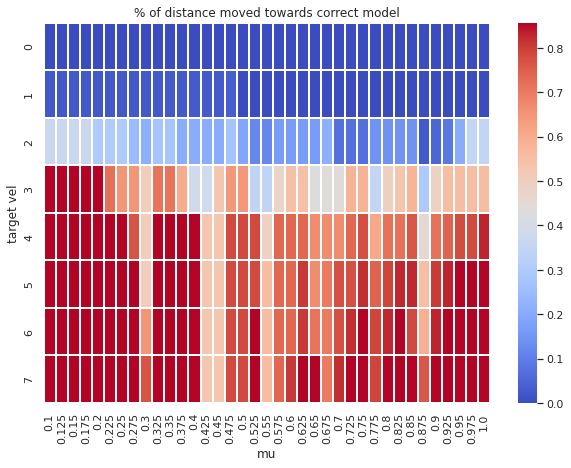

In [30]:
heatMap = np.zeros((7 + 1, 37))
print(heatMap.shape)
for i in range(len(dfs)):
  distance_to_correct_model_end = np.abs(dfs[i].target_model.iloc[0] - dfs[i].current_model.iloc[-1])
  distance_to_correct_model_start = np.abs(dfs[i].target_model.iloc[0] - dfs[i].current_model.iloc[0])
  #if distance_to_correct_model_start != 0 and dfs[i].current_model.iloc[0] == 6:
  if distance_to_correct_model_start != 0:
    heatMap[int(dfs[i].target_vel.iloc[0]), int(np.round((dfs[i].mu.iloc[0] - 0.1) / 0.025))] += (np.abs(distance_to_correct_model_end-distance_to_correct_model_start) / distance_to_correct_model_start) / 7

labelsx = np.round(np.linspace(0.1, 1.0, 37), 3)
labelsy = [0, 1, 2, 3, 4, 5, 6, 7]
df_cm = pd.DataFrame(heatMap, index = labelsy,
                  columns = labelsx)

print(labelsx)
plt.figure(figsize = (10,7))
plt.title('% of distance moved towards correct model')
sns.heatmap(df_cm, annot=False, linewidths=1, linecolor='white', cmap='coolwarm')
plt.xlabel('mu')
plt.ylabel('target vel')

[[0.02123309]
 [3.32770415]
 [8.71783118]
 [8.38757164]
 [7.61849062]
 [7.00350021]
 [6.1567363 ]]


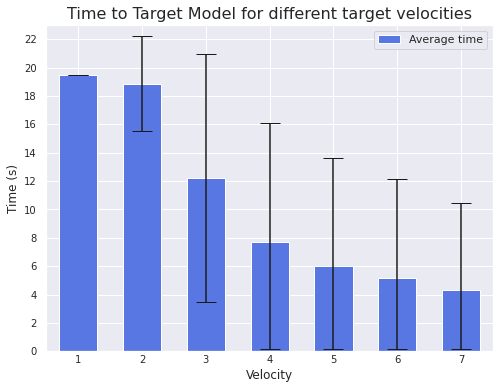

In [31]:
counter = np.zeros((7, 1))
sum = np.zeros((7, 1))
squareError = np.zeros((7, 1))
times = [[],[],[],[],[],[],[]]

for i in range(len(dfs)):
  indexStart = dfs[i][dfs[i].desired_velocity != 0].index[0]

  if np.abs(dfs[i].target_model.iloc[0] - dfs[i].current_model.iloc[-1]) == 0 and dfs[i].current_model.iloc[0] != dfs[i].target_model.iloc[0]:
    indexGoal = dfs[i][dfs[i].current_model == dfs[i].target_model.iloc[0]].index[0]
    sum[int(dfs[i].target_vel.iloc[0]) - 1] += dfs[i].time.iloc[indexGoal] - dfs[i].time.iloc[indexStart]
    counter[int(dfs[i].target_vel.iloc[0]) - 1] += 1
  elif np.abs(dfs[i].target_model.iloc[0] - dfs[i].current_model.iloc[-1]) != 0 and dfs[i].current_model.iloc[0] != dfs[i].target_model.iloc[0]:
    sum[int(dfs[i].target_vel.iloc[0]) - 1] += dfs[i].time.iloc[-1] - dfs[i].time.iloc[indexStart]
    counter[int(dfs[i].target_vel.iloc[0]) - 1] += 1


#Sum becomes mean
for i in range(7):
  if counter[i] != 0:
    sum[i] /= counter[i]

for i in range(len(dfs)):
  indexStart = dfs[i][dfs[i].desired_velocity != 0].index[0]

  if np.abs(dfs[i].target_model.iloc[0] - dfs[i].current_model.iloc[-1]) == 0 and dfs[i].current_model.iloc[0] != dfs[i].target_model.iloc[0]:
    indexGoal = dfs[i][dfs[i].current_model == dfs[i].target_model.iloc[0]].index[0]
    squareError[int(dfs[i].target_vel.iloc[0]) - 1] += (sum[int(dfs[i].target_vel.iloc[0]) - 1] - (dfs[i].time.iloc[indexGoal] - dfs[i].time.iloc[indexStart]))**2

  if np.abs(dfs[i].target_model.iloc[0] - dfs[i].current_model.iloc[-1]) != 0 and dfs[i].current_model.iloc[0] != dfs[i].target_model.iloc[0]:
        squareError[int(dfs[i].target_vel.iloc[0]) - 1] += (sum[int(dfs[i].target_vel.iloc[0]) - 1] - (dfs[i].time.iloc[-1] - dfs[i].time.iloc[indexStart]))**2

std= np.zeros((7, 1))
for i in range(7):
  std[i] = np.sqrt(squareError[i] / counter[i])



## New method
for df in dfs:
  indexStart = df[df.desired_velocity != 0].index[0]

  if np.abs(df.target_model.iloc[0] - df.current_model.iloc[-1]) == 0 and df.current_model.iloc[0] != df.target_model.iloc[0]:
    indexGoal = df[df.current_model == df.target_model.iloc[0]].index[0]
    timeTaken = df.time.iloc[indexGoal] - df.time.iloc[indexStart]
  elif np.abs(df.target_model.iloc[0] - df.current_model.iloc[-1]) != 0 and df.current_model.iloc[0] != df.target_model.iloc[0]:
    timeTaken = df.time.iloc[-1] - df.time.iloc[indexStart]

  times[int(df.target_vel.iloc[0]) - 1].append(timeTaken)


print(std)
# Define the data
velocities = [1, 2, 3, 4, 5, 6, 7]

# Set the figure size
plt.figure(figsize=(8,6))
yErrors = np.zeros((2, 7))
for i in range(len(std)):
  if sum[i] - std[i] < 0:
    yErrors[0, i] = sum[i] - 0.15
    yErrors[1, i] = std[i]
  else:
    yErrors[0, i] = std[i]
    yErrors[1, i] = std[i]

plt.bar(velocities, sum.reshape((7,)), color=plt.cm.coolwarm(0.1), width=0.6, alpha=1.0, label='Average time', yerr = yErrors, capsize = 10)
#plt.bar(velocities, std.reshape((7,)), align='edge', color='#B40426', width=-0.3, alpha=1.0, label='Standard deviance')
#for v in velocities:
  #plt.plot([0.5,v + 0.3], [sum.reshape((7,))[v-1], sum.reshape((7,))[v-1]], 'black', linestyle='dotted', linewidth=1.0)

#plt.boxplot(times)
# Add labels and title
plt.xlabel('Velocity', fontsize=12)
plt.ylabel('Time (s)', fontsize=12)
plt.title('Time to Target Model for different target velocities', fontsize=16)
# Set the x-axis ticks and labels
plt.xticks(velocities, fontsize=10)
plt.tick_params(axis='x', length=0)
# Set the y-axis limits and ticks
plt.xlim(0.5, 7.5)
plt.ylim(0, 23)
plt.yticks(np.arange(0, 24, 2.0), fontsize=10)
# Show the plot
plt.legend()
plt.savefig('TimeTargetModelVelocity.pdf')
plt.show()

6
model end: 5.0


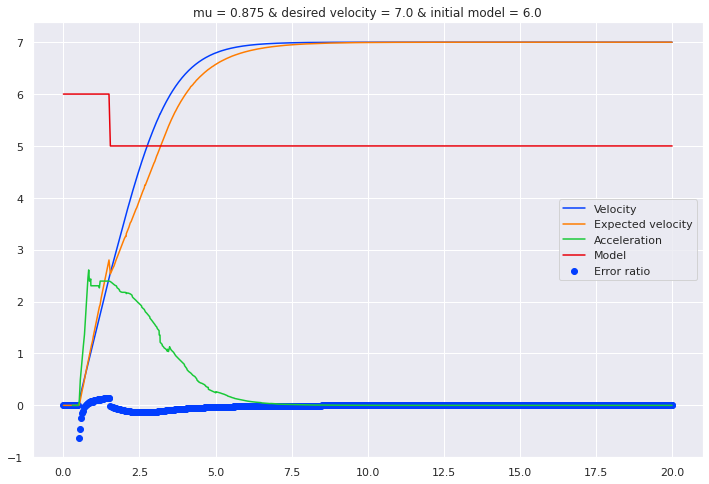

In [32]:
# 0.3 7.0 0.0

print(GetTargetModel(0.875))
vel = 7.0
mod = 6.0
sur = 0.875
for df in dfs:
  if df.target_vel.iloc[0] == vel and df.current_model.iloc[0] == mod and df.mu.iloc[0] == sur:
    plt.plot(df.time.iloc[:],df.speed.iloc[:], label='Velocity')
    
    plt.plot(df.time.iloc[:],df.expected_velocity.iloc[:], label='Expected velocity')
    
    plt.plot(df.time.iloc[:],df.acc.iloc[:], label='Acceleration')
    
    #plt.plot(df.time.iloc[:],df.flag.iloc[:], label='Flag')
    #plt.plot(df.time.iloc[:],df.vel_diff.iloc[:], label='Vel_diff')
    #plt.plot(df.time.iloc[:],df.action.iloc[:], label='Action')
    
    plt.plot(df.time.iloc[:],df.current_model.iloc[:], label='Model')

    plt.scatter(df.time.iloc[:],df.slip_ratio.iloc[:], label='Error ratio')


# ------------------------ NOT USED ------------------------------------------------------
    #plt.scatter(df.time.iloc[:],df.optimal_vel.iloc[:], label = 'Optimal velocity.x')
    #plt.plot(df.time.iloc[:],df.optimal_acc.iloc[:], label='Optimal Acceleration')
    #plt.plot(df.time.iloc[:],df.expected_acc.iloc[:], label='Expected Acceleration')
    #plt.plot(df.time.iloc[:],df.model_active.iloc[:], label='Model Active')
    #plt.plot(df.time.iloc[:],df.desired_velocity.iloc[:], label='Desired velocity')
    #plt.plot(df.time.iloc[:],df.jerk.iloc[:], label='Jerk')

    #plt.ylim(-0.5,1.5)
    #t = df.action.diff().to_numpy().nonzero()

    print("model end: " + str(df.current_model.iloc[-1]))

    plt.title("mu = " + str(df.mu.iloc[0])+" & desired velocity = "+str(df.desired_velocity.iloc[-1]) + " & initial model = "+str(df.current_model.iloc[0]))
    plt.legend()


    plt.savefig("example_sim.pdf")
    plt.show()

[17, 259, 263, 231, 189, 151, 99]


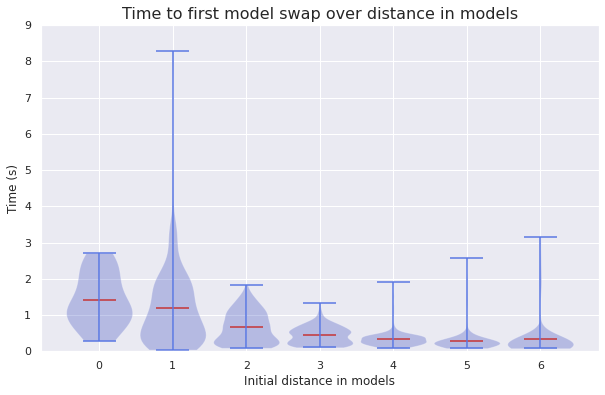

3.0 & 0.8 & 0.0 & 5.0 \\
2.0 & 0.875 & 0.0 & 6.0 \\
2.0 & 0.925 & 1.0 & 5.0 \\
2.0 & 1.0 & 1.0 & 5.0 \\
2.0 & 0.975 & 2.0 & 4.0 \\
1.0 & 0.425 & 6.0 & 5.0 \\
7.0 & 0.3 & 1.0 & 1.0 \\
2.0 & 0.975 & 1.0 & 5.0 \\
2.0 & 0.95 & 1.0 & 5.0 \\
2.0 & 0.95 & 3.0 & 3.0 \\
2.0 & 1.0 & 0.0 & 6.0 \\
2.0 & 0.95 & 0.0 & 6.0 \\
3.0 & 0.825 & 0.0 & 5.0 \\
2.0 & 0.975 & 0.0 & 6.0 \\
2.0 & 0.925 & 0.0 & 6.0 \\
1.0 & 0.45 & 6.0 & 5.0 \\
3.0 & 0.85 & 0.0 & 5.0 \\
2.0 & 0.9 & 0.0 & 6.0 \\
1.0 & 0.4 & 6.0 & 5.0 \\
7.0 & 0.65 & 4.0 & 1.0 \\
2.0 & 0.925 & 2.0 & 4.0 \\
2.0 & 0.95 & 2.0 & 4.0 \\
3.0 & 0.675 & 0.0 & 4.0 \\
6.0 & 0.3 & 1.0 & 1.0 \\
3.0 & 0.775 & 0.0 & 5.0 \\
2.0 & 0.9 & 1.0 & 5.0 \\
2.0 & 1.0 & 2.0 & 4.0 \\


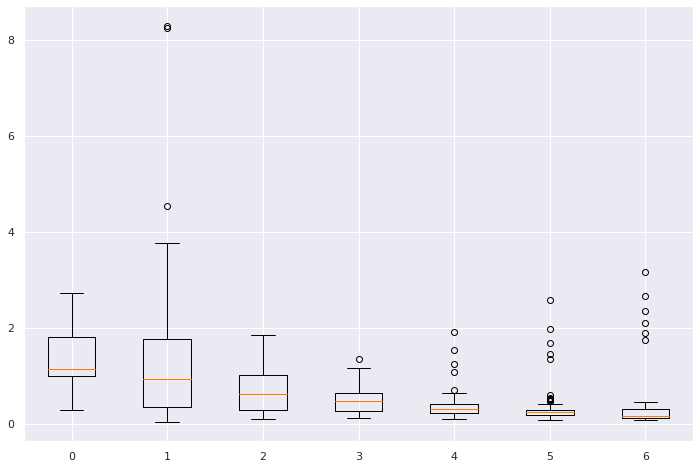

In [33]:
#####################################
pointsX = []
pointsY = []
counter = [0, 0, 0, 0, 0, 0, 0]
violin = [[], [], [], [], [], [], []]

for df in dfs:
  if df.current_model.iloc[0] != df.current_model.iloc[-1]:
    indexStart = df[df.desired_velocity != 0].index[0]
    indexGoal = df[df.current_model != df.current_model.iloc[0]].index[0]

    timeTaken = df.time.iloc[indexGoal] - df.time.iloc[indexStart]

    distance_to_correct_model_start = np.abs(df.target_model.iloc[0] - df.current_model.iloc[0])
    #if distance_to_correct_model_start == 0:
      #print(df.mu.iloc[0], df.target_vel.iloc[0], df.current_model.iloc[0])
    
    pointsY.append(timeTaken)
    pointsX.append(distance_to_correct_model_start)
    counter[int(distance_to_correct_model_start)] += 1

    violin[int(distance_to_correct_model_start)].append(timeTaken)

print(counter)
# Define the data
distances = [0, 1, 2, 3, 4, 5, 6]

# Set the figure size
plt.figure(figsize=(10,6))

#plt.scatter(pointsX, pointsY)
colormap = plt.cm.coolwarm
vio = plt.violinplot(violin, positions = distances, vert = True, showmeans= True, widths = 0.9)
vio['cmeans'].set_color(colormap(0.95))
vio['cmaxes'].set_color(colormap(0.1))
vio['cbars'].set_color(colormap(0.1))
vio['cmins'].set_color(colormap(0.1))
# Apply coolwarm colormap to the violins

for patch in plt.gca().collections:
    patch.set_facecolor(colormap(0.0))
# Add labels and title
plt.xlabel('Initial distance in models', fontsize=12)
plt.ylabel('Time (s)', fontsize=12)
plt.title('Time to first model swap over distance in models', fontsize=16)
# Set the x-axis ticks and labels
# plt.yticks(distances, fontsize=10)
# plt.tick_params(axis='x', length=0)
# Set the y-axis limits and ticks
plt.ylim(0, 9)
# plt.yticks(np.arange(0, 20, 1.0), fontsize=10)
# Add grid lines
# plt.grid(axis='y', linestyle='--', alpha=0.6, color='Grey')
# Show the plot
plt.savefig("violin.pdf")
plt.show()

outliers = plt.boxplot(violin, positions = distances)['fliers']

for df in dfs:
  if df.current_model.iloc[0] != df.current_model.iloc[-1]:
    indexStart = df[df.desired_velocity != 0].index[0]
    indexGoal = df[df.current_model != df.current_model.iloc[0]].index[0]

    timeTaken = df.time.iloc[indexGoal] - df.time.iloc[indexStart]

    distance_to_correct_model_start = np.abs(df.target_model.iloc[0] - df.current_model.iloc[0])

    if len(outliers[int(distance_to_correct_model_start)].get_data()[1]) > 0:
      if timeTaken >= np.min(outliers[int(distance_to_correct_model_start)].get_data()[1]):
        print(df.target_vel.iloc[0], "&", df.mu.iloc[0], "&", df.current_model.iloc[0], "&", distance_to_correct_model_start, "\\\\")


6


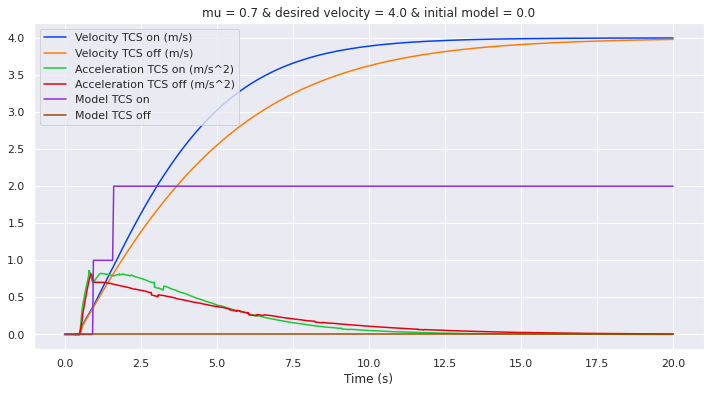

In [34]:
# 0.3 7.0 0.0
rcParams['figure.figsize'] = 12, 6
print(GetTargetModel(0.875))
vel = 4.0
mod = 0.0
sur = 0.7

for df in dfs:
  if df.target_vel.iloc[0] == vel and df.current_model.iloc[0] == mod and df.mu.iloc[0] == sur:
    
    
    #plt.plot(df.time.iloc[:],df.expected_velocity.iloc[:], label='Expected velocity.x')
    #plt.scatter(df.time.iloc[:],df.slip_ratio.iloc[:], label='Slip ratio')
    
    
    
    #plt.plot(df.time.iloc[:],df.flag.iloc[:], label='Flag')
    #plt.plot(df.time.iloc[:],df.vel_diff.iloc[:], label='Vel_diff')
    #plt.plot(df.time.iloc[:],df.action.iloc[:], label='Action')
    for df_off in dfs_off:
      if df_off.target_vel.iloc[0] == vel and df_off.current_model.iloc[0] == mod and df_off.mu.iloc[0] == sur:
        plt.plot(df.time.iloc[:],df.speed.iloc[:], label='Velocity TCS on (m/s)')
        plt.plot(df_off.time.iloc[:],df_off.speed.iloc[:], label='Velocity TCS off (m/s)')

        plt.plot(df.time.iloc[:],df.acc.iloc[:], label='Acceleration TCS on (m/s^2)')
        plt.plot(df_off.time.iloc[:],df_off.acc.iloc[:], label='Acceleration TCS off (m/s^2)')

        plt.plot(df.time.iloc[:],df.current_model.iloc[:], label='Model TCS on')
        plt.plot(df_off.time.iloc[:],df_off.current_model.iloc[:], label='Model TCS off')
        plt.title("mu = " + str(df.mu.iloc[0])+" & desired velocity = "+str(df.desired_velocity.iloc[-1]) + " & initial model = "+str(df.current_model.iloc[0]))

plt.xlabel("Time (s)")
plt.legend()

plt.savefig("compare_4_07_0.pdf")
plt.show()

6


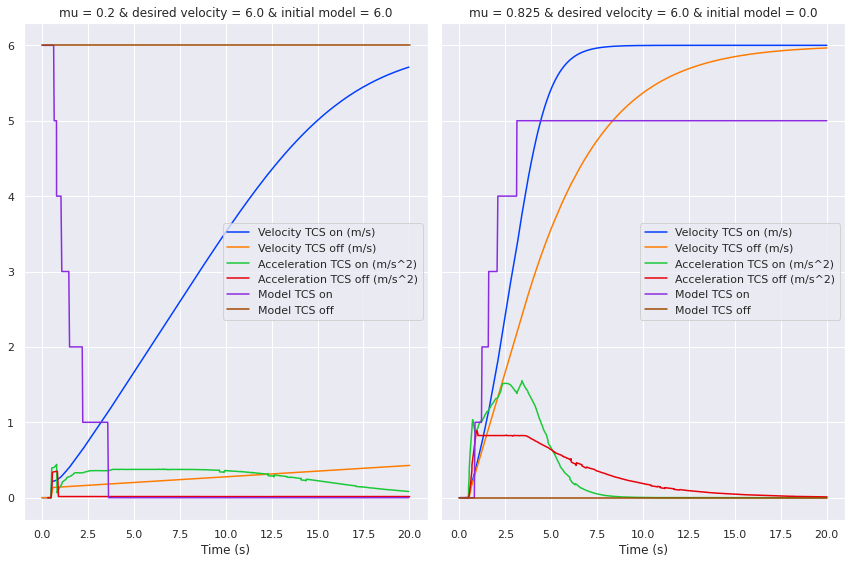

In [35]:
# 0.3 7.0 0.0

print(GetTargetModel(0.875))
vel = 6.0
mod = 6.0
sur = 0.2

rcParams['figure.figsize'] = 12, 8
fig, axs = plt.subplots(1, 2, sharey=True)

for df in dfs:
  if df.target_vel.iloc[0] == vel and df.current_model.iloc[0] == mod and df.mu.iloc[0] == sur:
    
    
    #plt.plot(df.time.iloc[:],df.expected_velocity.iloc[:], label='Expected velocity.x')
    #plt.scatter(df.time.iloc[:],df.slip_ratio.iloc[:], label='Slip ratio')
    
    
    
    #plt.plot(df.time.iloc[:],df.flag.iloc[:], label='Flag')
    #plt.plot(df.time.iloc[:],df.vel_diff.iloc[:], label='Vel_diff')
    #plt.plot(df.time.iloc[:],df.action.iloc[:], label='Action')
    for df_off in dfs_off:
      if df_off.target_vel.iloc[0] == vel and df_off.current_model.iloc[0] == mod and df_off.mu.iloc[0] == sur:
        axs[0].plot(df.time.iloc[:],df.speed.iloc[:], label='Velocity TCS on (m/s)')
        axs[0].plot(df_off.time.iloc[:],df_off.speed.iloc[:], label='Velocity TCS off (m/s)')

        axs[0].plot(df.time.iloc[:],df.acc.iloc[:], label='Acceleration TCS on (m/s^2)')
        axs[0].plot(df_off.time.iloc[:],df_off.acc.iloc[:], label='Acceleration TCS off (m/s^2)')

        axs[0].plot(df.time.iloc[:],df.current_model.iloc[:], label='Model TCS on')
        axs[0].plot(df_off.time.iloc[:],df_off.current_model.iloc[:], label='Model TCS off')
        axs[0].set_title("mu = " + str(df.mu.iloc[0])+" & desired velocity = "+str(df.desired_velocity.iloc[-1]) + " & initial model = "+str(df.current_model.iloc[0]))



# ------------------------------

vel = 6.0
mod = 0.0
sur = 0.825

for df in dfs:
  if df.target_vel.iloc[0] == vel and df.current_model.iloc[0] == mod and df.mu.iloc[0] == sur:
    
    
    #plt.plot(df.time.iloc[:],df.expected_velocity.iloc[:], label='Expected velocity.x')
    #plt.scatter(df.time.iloc[:],df.slip_ratio.iloc[:], label='Slip ratio')
    
    
    
    #plt.plot(df.time.iloc[:],df.flag.iloc[:], label='Flag')
    #plt.plot(df.time.iloc[:],df.vel_diff.iloc[:], label='Vel_diff')
    #plt.plot(df.time.iloc[:],df.action.iloc[:], label='Action')
    for df_off in dfs_off:
      if df_off.target_vel.iloc[0] == vel and df_off.current_model.iloc[0] == mod and df_off.mu.iloc[0] == sur:
        axs[1].plot(df.time.iloc[:],df.speed.iloc[:], label='Velocity TCS on (m/s)')
        axs[1].plot(df_off.time.iloc[:],df_off.speed.iloc[:], label='Velocity TCS off (m/s)')

        axs[1].plot(df.time.iloc[:],df.acc.iloc[:], label='Acceleration TCS on (m/s^2)')
        axs[1].plot(df_off.time.iloc[:],df_off.acc.iloc[:], label='Acceleration TCS off (m/s^2)')

        axs[1].plot(df.time.iloc[:],df.current_model.iloc[:], label='Model TCS on')
        axs[1].plot(df_off.time.iloc[:],df_off.current_model.iloc[:], label='Model TCS off')
        axs[1].set_title("mu = " + str(df.mu.iloc[0])+" & desired velocity = "+str(df.desired_velocity.iloc[-1]) + " & initial model = "+str(df.current_model.iloc[0]))

axs[0].set_xlabel("Time (s)")
axs[0].legend()
axs[1].set_xlabel("Time (s)")
axs[1].legend()

fig.tight_layout()

plt.savefig("compare_swap_up_and_down.pdf")
plt.show()


#
#axs[0].bar(names, values)
#axs[1].scatter(names, values)